In [1]:
#load model
from keras.models import load_model
model = load_model('CNN_trainedNetwork.h5')
model.summary()

Using TensorFlow backend.
W0729 13:17:16.769264 140666116888320 deprecation_wrapper.py:119] From /home/xsede3/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 13:17:16.860260 140666116888320 deprecation_wrapper.py:119] From /home/xsede3/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 13:17:16.903727 140666116888320 deprecation_wrapper.py:119] From /home/xsede3/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0729 13:17:16.979203 140666116888320 deprecation_wrapper.py:119] From /home/xsede3/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_defa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      3488      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
__________

In [2]:
#Visualizing intermediate activations 
# Preprocessing a single image

img_path = '/home/xsede3/xsedesummer2019/medical/img/original_images/00015013_011.png'
from keras.preprocessing import image 
import numpy as np
img = image.load_img(img_path, target_size=(128, 128)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.
print(img_tensor.shape)

(1, 128, 128, 3)


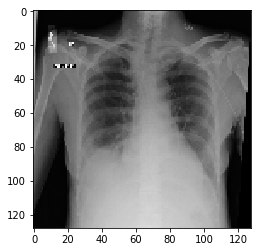

In [3]:
# Displaying the test picture
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_tensor[0]) 
plt.show()


In [69]:
# Instantiating a model from an input tensor and a list of output tensors
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [70]:
# Running the model in predict mode
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0] 
print(first_layer_activation.shape) 

(1, 128, 128, 32)


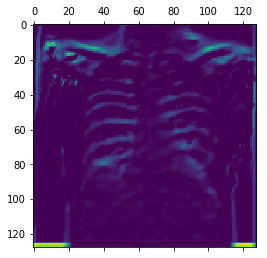

In [71]:
#Visualizing the 10th channel

import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')


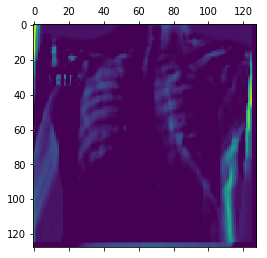

In [72]:
# Visualizing the seventh channel
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')


In [73]:
#Visualizing every channel in every intermediate activation
layer_names = [] #names of layers for our plot
for layer in model.layers[:8]: 
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): #displayes features maps
    n_features = layer_activation.shape[-1] #number of features in the map
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row # tiles the channels
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols): #tiles each filter
        for row in range(images_per_row): #for post processing od feature to make it visibly palatable
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() 
            channel_image /= channel_image.std() 
            channel_image *= 64 
            channel_image += 128 
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image 
            #^displays grid
scale = 1. / size 
plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])) 
plt.title(layer_name) 
plt.grid(False) 
plt.imshow(display_grid, aspect='auto', cmap='viridis')

MemoryError: 

In [37]:
# Visualizing convnet filters 


In [38]:
# Defining the loss tensor for filter visualization
from keras.applications import VGG16 
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block3_conv1' 
filter_index = 0

layer_output = model.get_layer(layer_name).output 
loss = K.mean(layer_output[:, :, :, filter_index])


In [39]:
#Obtaining the gradient of the loss with regard to the input
grads = K.gradients(loss, model.input)[0]


In [40]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)


In [41]:
iterate = K.function([model.input], [loss, grads])
import numpy as np 
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [42]:
# Loss maximization via stochastic gradient descent
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1. 

for i in range(40): 
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step


In [43]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5 
    x = np.clip(x, 0, 1)
    
    x *= 255 
    x = np.clip(x, 0, 255).astype('uint8') 
    return x


In [44]:
#Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=150): 
    layer_output = model.get_layer(layer_name).output 
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1. 
    for i in range(40): 
        loss_value, grads_value = iterate([input_img_data]) 
        input_img_data += grads_value * step
    img = input_img_data[0] 
    return deprocess_image(img)


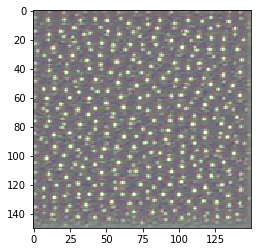

In [45]:
 plt.imshow(generate_pattern('block3_conv1', 0))


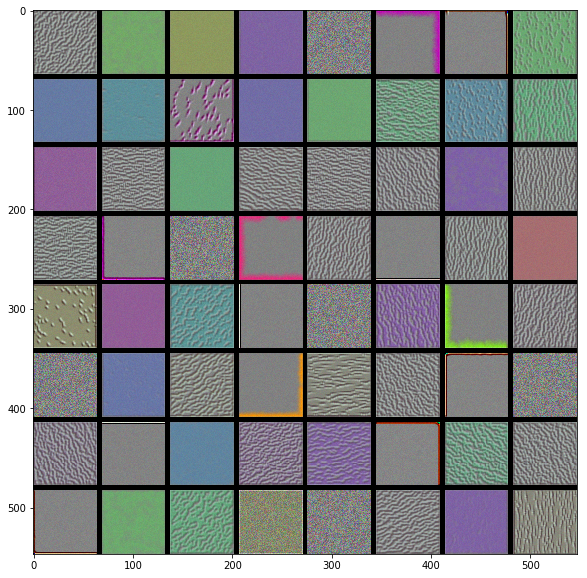

In [51]:
#Generating a grid of all filter response patterns in a layer
layer_name = 'block1_conv1' 
size = 64
margin = 5

results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8): 
    for j in range(8): 
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i *margin 
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j *margin 
        vertical_end = vertical_start + size 
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(10, 10)) 
plt.imshow((results * 255).astype(np.uint8))

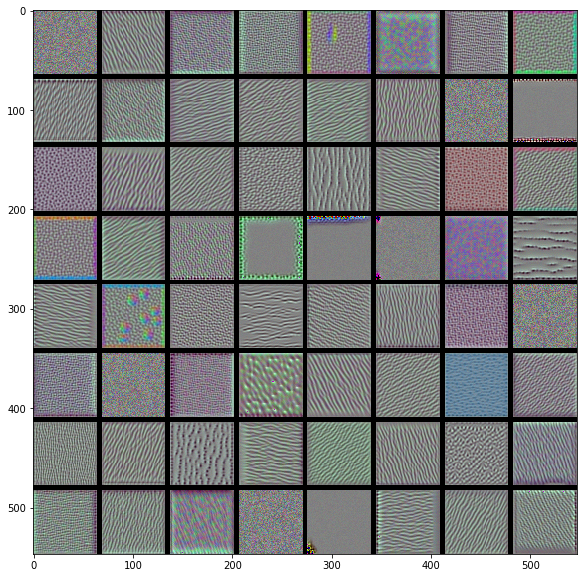

In [52]:
layer_name = 'block2_conv1' 
size = 64
margin = 5

results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8): 
    for j in range(8): 
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i *margin 
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j *margin 
        vertical_end = vertical_start + size 
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(10, 10)) 
plt.imshow((results * 255).astype(np.uint8))

In [ ]:
layer_name = 'block3_conv1' 
size = 64
margin = 5

results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8): 
    for j in range(8): 
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i *margin 
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j *margin 
        vertical_end = vertical_start + size 
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(10, 10)) 
plt.imshow((results * 255).astype(np.uint8))

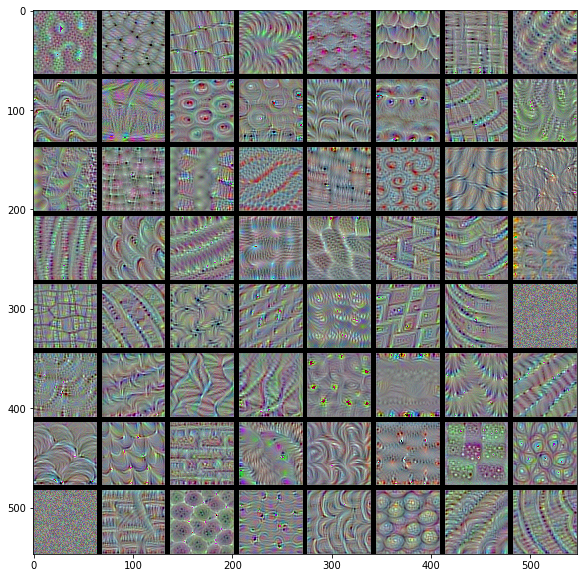

In [53]:
layer_name = 'block4_conv1' 
size = 64
margin = 5

results = np.zeros((8 * size+7*margin, 8 * size+7*margin, 3))
for i in range(8): 
    for j in range(8): 
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
        horizontal_start = i * size + i *margin 
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j *margin 
        vertical_end = vertical_start + size 
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
plt.figure(figsize=(10, 10)) 
plt.imshow((results * 255).astype(np.uint8))

In [4]:
from keras.applications.vgg16 import VGG16
model = load_model('CNN_PretrainedNetwork.h5')
model.summary()
#model = model.load_weights(r'/home/xsede3/xsedesummer2019/medical/CNN_PretrainedNetwork.h5')
#models = VGG16(weights='imagenet', include_top=False)
#models.load_weights(r'/home/xsede3/xsedesummer2019/medical/CNN_PretrainedNetwork.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 15)                3855      
Total params: 16,815,951
Trainable params: 9,180,687
Non-trainable params: 7,635,264
_________________________________________________________________


In [5]:
#model.load_weights(r'/home/xsede3/xsedesummer2019/medical/CNN_PretrainedNetwork.h5')


In [6]:
#Visualizing heatmaps of class activation
from keras.preprocessing import image 
from keras.applications.vgg16 import preprocess_input, decode_predictions 
import numpy as np
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 15)                3855      
Total params: 16,815,951
Trainable params: 9,180,687
Non-trainable params: 7,635,264
_________________________________________________________________


In [7]:
#Visualizing intermediate activations 
# Preprocessing a single image

img_path = '/home/xsede3/xsedesummer2019/medical/img/original_images/00015013_011.png'
from keras.preprocessing import image 
import numpy as np
img = image.load_img(img_path, target_size=(128, 128)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.
print(img_tensor.shape)

(1, 128, 128, 3)


In [8]:
preds = model.predict(img_tensor)
#print('Predicted:', decode_predictions(preds, top=3)[0])

In [9]:
from keras import backend as K
np.argmax(preds[0])

10

In [12]:
#nevermind; ignore
def getMaxProbability (input):
    maxProb = np.amax(input)
    return (maxProb)

def getIndex(inputArray):
    result = np.where(inputArray == 9.927406)
    return (result)

print(getIndex(preds))


(array([], dtype=int64), array([], dtype=int64))


In [10]:
preds

array([[0.10330737, 0.0351651 , 0.08643669, 0.04746914, 0.20113102,
        0.01036152, 0.01591048, 0.00077075, 0.22849482, 0.09432971,
        0.42785504, 0.09419841, 0.02269474, 0.01588334, 0.02935369]],
      dtype=float32)

In [11]:
print(model.output[:,10])
last_conv_layer = model.get_layer('dense_4')
print(last_conv_layer)

Tensor("strided_slice:0", shape=(?,), dtype=float32)


In [17]:
#understanding each line
disease_output = model.output[:,10]
last_conv_layer = model.get_layer('dense_4')

grads = K.gradients(disease_output, last_conv_layer.output)[0]
print(grads)
pooled_grads = K.mean(grads, axis=(0,1))
print(pooled_grads)

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
print(conv_layer_output_value)

print(pooled_grads_value)
for i in range(15): 
    conv_layer_output_value[i] *= pooled_grads_value
print(conv_layer_output_value)
print(pooled_grads_value)

Tensor("gradients_2/strided_slice_5_grad/StridedSliceGrad:0", shape=(?, 15), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
[0.10330737 0.0351651  0.08643669 0.04746914 0.20113102 0.01036152
 0.01591048 0.00077075 0.22849482 0.09432971 0.42785504 0.09419841
 0.02269474 0.01588334 0.02935369]
0.06666667
[6.8871579e-03 2.3443403e-03 5.7624462e-03 3.1646094e-03 1.3408735e-02
 6.9076818e-04 1.0606985e-03 5.1383180e-05 1.5232989e-02 6.2886481e-03
 2.8523671e-02 6.2798942e-03 1.5129825e-03 1.0588891e-03 1.9569127e-03]
0.06666667


In [20]:
# Setting up the Grad-CAM algorithm
#maxProbIndex = getIndex(preds)
disease_output = model.output[:,10]
last_conv_layer = model.get_layer('dense_4')

grads = K.gradients(disease_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([img_tensor])
for i in range(15): 
    conv_layer_output_value[i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=0)
print(heatmap)


IndexError: invalid index to scalar variable.

In [19]:
#  normalize the heatmap between 0 and 1. 
heatmap = np.maximum(heatmap, 0) 
print(heatmap)
heatmap /= np.max(heatmap) 
print(heatmap)

plt.matshow(heatmap)

0.006281608249992132
1.0


ValueError: not enough values to unpack (expected 2, got 0)

In [16]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/home/xsede3/xsedesummer2019/medical/gradCamImg.png', superimposed_img)


True